In [1]:
import os
os.listdir("../input/plant-diseases-classification-using-alexnet")

['__results__.html',
 '__output__.json',
 '__results___files',
 'AlexNetModel.hdf5',
 'custom.css',
 'best_weights_9.hdf5']

**Building CNN Based On AlexNet Architecture**

In [2]:
# Importing Keras libraries and packages
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers.normalization import BatchNormalization

# Initializing the CNN
classifier = Sequential()

# Convolution Step 1
classifier.add(Convolution2D(96, 11, strides = (4, 4), padding = 'valid', input_shape=(224, 224, 3), activation = 'relu'))

# Max Pooling Step 1
classifier.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'valid'))
classifier.add(BatchNormalization())

# Convolution Step 2
classifier.add(Convolution2D(256, 11, strides = (1, 1), padding='valid', activation = 'relu'))

# Max Pooling Step 2
classifier.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding='valid'))
classifier.add(BatchNormalization())

# Convolution Step 3
classifier.add(Convolution2D(384, 3, strides = (1, 1), padding='valid', activation = 'relu'))
classifier.add(BatchNormalization())

# Convolution Step 4
classifier.add(Convolution2D(384, 3, strides = (1, 1), padding='valid', activation = 'relu'))
classifier.add(BatchNormalization())

# Convolution Step 5
classifier.add(Convolution2D(256, 3, strides=(1,1), padding='valid', activation = 'relu'))

# Max Pooling Step 3
classifier.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'valid'))
classifier.add(BatchNormalization())

# Flattening Step
classifier.add(Flatten())

# Full Connection Step
classifier.add(Dense(units = 4096, activation = 'relu'))
classifier.add(Dropout(0.4))
classifier.add(BatchNormalization())
classifier.add(Dense(units = 4096, activation = 'relu'))
classifier.add(Dropout(0.4))
classifier.add(BatchNormalization())
classifier.add(Dense(units = 1000, activation = 'relu'))
classifier.add(Dropout(0.2))
classifier.add(BatchNormalization())
classifier.add(Dense(units = 38, activation = 'softmax'))
classifier.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 54, 54, 96)        34944     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 27, 27, 96)        384       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 256)       2973952   
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 8, 256)         1024      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 6, 384)         885120    
__________

**Loading Weights To The Model**

In [3]:
classifier.load_weights('../input/plant-diseases-classification-using-alexnet/best_weights_9.hdf5')

**Fine Tuning By Freezing Some Layers Of Our Model**

In [4]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
from keras import layers
for i, layer in enumerate(classifier.layers):
   print(i, layer.name)

0 conv2d_1
1 max_pooling2d_1
2 batch_normalization_1
3 conv2d_2
4 max_pooling2d_2
5 batch_normalization_2
6 conv2d_3
7 batch_normalization_3
8 conv2d_4
9 batch_normalization_4
10 conv2d_5
11 max_pooling2d_3
12 batch_normalization_5
13 flatten_1
14 dense_1
15 dropout_1
16 batch_normalization_6
17 dense_2
18 dropout_2
19 batch_normalization_7
20 dense_3
21 dropout_3
22 batch_normalization_8
23 dense_4


In [5]:
# we chose to train the top 2 conv blocks, i.e. we will freeze
# the first 8 layers and unfreeze the rest:
print("Freezed layers:")
for i, layer in enumerate(classifier.layers[:20]):
    print(i, layer.name)
    layer.trainable = False


Freezed layers:
0 conv2d_1
1 max_pooling2d_1
2 batch_normalization_1
3 conv2d_2
4 max_pooling2d_2
5 batch_normalization_2
6 conv2d_3
7 batch_normalization_3
8 conv2d_4
9 batch_normalization_4
10 conv2d_5
11 max_pooling2d_3
12 batch_normalization_5
13 flatten_1
14 dense_1
15 dropout_1
16 batch_normalization_6
17 dense_2
18 dropout_2
19 batch_normalization_7


**Model Summary After Freezing**

In [6]:
#trainable parameters decrease after freezing some bottom layers   
classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 54, 54, 96)        34944     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 27, 27, 96)        384       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 256)       2973952   
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 8, 256)         1024      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 6, 384)         885120    
__________

**Compiling the Model**

In [7]:
# Compiling the Model
from keras import optimizers
classifier.compile(optimizer=optimizers.SGD(lr=0.001, momentum=0.9, decay=0.005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

**Image Preprocessing**

In [8]:
# image preprocessing
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 128
base_dir = "../input/new-plant-diseases-dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)"

training_set = train_datagen.flow_from_directory(base_dir+'/train',
                                                 target_size=(224, 224),
                                                 batch_size=batch_size,
                                                 class_mode='categorical')

valid_set = valid_datagen.flow_from_directory(base_dir+'/valid',
                                            target_size=(224, 224),
                                            batch_size=batch_size,
                                            class_mode='categorical')

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


In [9]:
class_dict = training_set.class_indices
print(class_dict)

{'Apple___Apple_scab': 0, 'Apple___Black_rot': 1, 'Apple___Cedar_apple_rust': 2, 'Apple___healthy': 3, 'Blueberry___healthy': 4, 'Cherry_(including_sour)___Powdery_mildew': 5, 'Cherry_(including_sour)___healthy': 6, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 7, 'Corn_(maize)___Common_rust_': 8, 'Corn_(maize)___Northern_Leaf_Blight': 9, 'Corn_(maize)___healthy': 10, 'Grape___Black_rot': 11, 'Grape___Esca_(Black_Measles)': 12, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 13, 'Grape___healthy': 14, 'Orange___Haunglongbing_(Citrus_greening)': 15, 'Peach___Bacterial_spot': 16, 'Peach___healthy': 17, 'Pepper,_bell___Bacterial_spot': 18, 'Pepper,_bell___healthy': 19, 'Potato___Early_blight': 20, 'Potato___Late_blight': 21, 'Potato___healthy': 22, 'Raspberry___healthy': 23, 'Soybean___healthy': 24, 'Squash___Powdery_mildew': 25, 'Strawberry___Leaf_scorch': 26, 'Strawberry___healthy': 27, 'Tomato___Bacterial_spot': 28, 'Tomato___Early_blight': 29, 'Tomato___Late_blight': 30, 'Tomato

In [10]:
li = list(class_dict.keys())
print(li)

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Sp

In [11]:
train_num = training_set.samples
valid_num = valid_set.samples

In [12]:
# checkpoint
from keras.callbacks import ModelCheckpoint
weightpath = "best_weights_9.hdf5"
checkpoint = ModelCheckpoint(weightpath, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=True, mode='max')
callbacks_list = [checkpoint]

#fitting images to CNN
history = classifier.fit_generator(training_set,
                         steps_per_epoch=train_num//batch_size,
                         validation_data=valid_set,
                         epochs=1,
                         validation_steps=valid_num//batch_size,
                         callbacks=callbacks_list)
#saving model
filepath="AlexNetModel.hdf5"
classifier.save(filepath)

Epoch 1/1
549/549 [==============================] - 2796s 5s/step - loss: 0.0935 - acc: 0.9684 - val_loss: 0.1071 - val_acc: 0.9628

Epoch 00001: val_acc improved from -inf to 0.96276, saving model to best_weights_9.hdf5


**Visualising Training Progress**

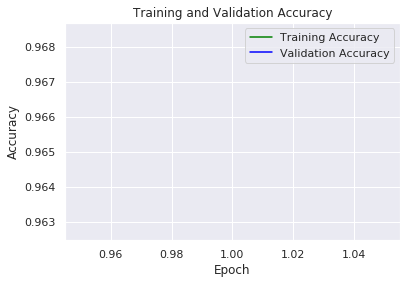

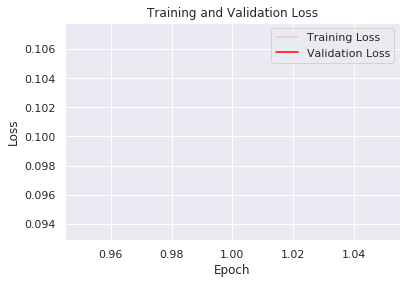

In [13]:
#plotting training values
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

#accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure()
#loss plot
plt.plot(epochs, loss, color='pink', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

**Predicting New Test Image(s)**

Following is our prediction:


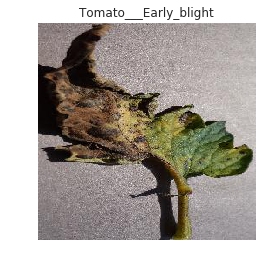

In [14]:
# predicting an image
from keras.preprocessing import image
import numpy as np
image_path = "../input/new-plant-diseases-dataset/test/test/TomatoEarlyBlight1.JPG"
new_img = image.load_img(image_path, target_size=(224, 224))
img = image.img_to_array(new_img)
img = np.expand_dims(img, axis=0)
img = img/255

print("Following is our prediction:")
prediction = classifier.predict(img)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
d = prediction.flatten()
j = d.max()
for index,item in enumerate(d):
    if item == j:
        class_name = li[index]

##Another way
# img_class = classifier.predict_classes(img)
# img_prob = classifier.predict_proba(img)
# print(img_class ,img_prob )


#ploting image with predicted class name        
plt.figure(figsize = (4,4))
plt.imshow(new_img)
plt.axis('off')
plt.title(class_name)
plt.show()